## Assignement 2
### Food Hazard Detection LGBM Model Benchmark Notebook

# Benchmarks - Basic Model: LightGBM 

In this task, we aim to classify food safety-related incidents based on two distinct types of input data: short texts (title) and long texts (text). 

Using Basic Model: LightGBM 


For each of these input types, we perform the following two subtasks:

**Subtasks (Performed Separately for  title and text):**

**Subtask 1:**

- Classify hazard-category (general hazard type).

- Classify product-category (general product type).

**Subtask 2:**

- Classify hazard (specific hazard).
- Classify product (specific product).

We use all features (year, month, day, country, and the text feature) as input.

Thus, we treat title and text as two distinct data sources, with each undergoing its own preprocessing, model training, and evaluation for all four targets.

## 1. Preprocessing and Splitting

In [13]:
import pandas as pd
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from sklearn.metrics import f1_score
import nltk



# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Function to clean text (title or text) and remove stopwords
def clean_text(text):
    # Remove non-alphanumeric characters (excluding spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = ' '.join(text.split())
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Assuming df is your DataFrame
df['title'] = df['title'].apply(clean_text)
df['text'] = df['text'].apply(clean_text)

# Define relevant features and targets
features = ['year', 'month', 'day', 'country']
targets_subtask1 = ['hazard-category', 'product-category']
targets_subtask2 = ['hazard', 'product']

# Function to prepare data for both title and text
def prepare_data(text_column):
    X = df[features + [text_column]]
    y_subtask1 = df[targets_subtask1]
    y_subtask2 = df[targets_subtask2]
    
    # Splitting data for both tasks
    data_splits = {}
    for target in targets_subtask1 + targets_subtask2:
        X_train, X_test, y_train, y_test = train_test_split(
            X, df[target], test_size=0.2, random_state=42
        )
        data_splits[target] = (X_train, X_test, y_train, y_test)
    
    return data_splits

# Prepare data for title and text
title_splits = prepare_data('title')
text_splits = prepare_data('text')



## 2. Build Pipelines and Train Models (LGBModel)

## Light GBM Classification Titles (Short Text):

In [14]:
import pandas as pd
from sklearn.metrics import f1_score, classification_report
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Initialize an empty DataFrame to store F1-scores
f1_scores_title_df = pd.DataFrame(columns=['Task', 'F1-Score'])



# Define LightGBM pipeline for title
def build_lgb_pipeline_title():
    preprocessor = ColumnTransformer(
        transformers=[
            ('text', TfidfVectorizer(), 'title'),  # Use TF-IDF for title text
            ('num', StandardScaler(), ['year', 'month', 'day']),
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['country'])
        ]
    )
    
    # LightGBM classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(num_leaves=80, learning_rate=0.05, n_estimators=300, verbose=-1))
    ])
    return pipeline

# Train and evaluate LightGBM for title
def train_and_evaluate_lgb_title(pipeline, data_splits, targets):
    global f1_scores_title_df
    for target in targets:
        X_train, X_test, y_train, y_test = data_splits[target]
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # Calculate F1-Score
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # Collect F1-score into DataFrame using pd.concat()
        f1_scores_title_df = pd.concat([f1_scores_title_df, pd.DataFrame({'Task': [f"{target} (Title)"], 'F1-Score': [f1]})], ignore_index=True)
        
        # Print the classification report
        print(f"\nClassification Report for {target} (Title):")
        print(classification_report(y_test, y_pred, zero_division=0))  # Handle zero division gracefully

# LightGBM for title
print("LightGBM for Titles:")
title_pipeline = build_lgb_pipeline_title()
train_and_evaluate_lgb_title(title_pipeline, title_splits, targets_subtask1 + targets_subtask2)




LightGBM for Titles:


C:\Users\steli\AppData\Local\Temp\ipykernel_18652\422926404.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  f1_scores_title_df = pd.concat([f1_scores_title_df, pd.DataFrame({'Task': [f"{target} (Title)"], 'F1-Score': [f1]})], ignore_index=True)



Classification Report for hazard-category (Title):
                                precision    recall  f1-score   support

                     allergens       0.82      0.90      0.86       377
                    biological       0.79      0.90      0.84       339
                      chemical       0.71      0.47      0.57        68
food additives and flavourings       0.50      0.20      0.29         5
                foreign bodies       0.73      0.69      0.71       111
                         fraud       0.68      0.50      0.58        68
                     migration       0.00      0.00      0.00         1
          organoleptic aspects       0.00      0.00      0.00        10
                  other hazard       0.67      0.22      0.33        27
              packaging defect       0.00      0.00      0.00        11

                      accuracy                           0.78      1017
                     macro avg       0.49      0.39      0.42      1017
          

## Light GBM Classification Texts (Long Text):

In [15]:
# Initialize an empty DataFrame to store F1-scores for text
f1_scores_text_df = pd.DataFrame(columns=['Task', 'F1-Score'])



# Define LightGBM pipeline for text
def build_lgb_pipeline_text():
    preprocessor = ColumnTransformer(
        transformers=[
            ('text', TfidfVectorizer(), 'text'),  # Use TF-IDF for text
            ('num', StandardScaler(), ['year', 'month', 'day']),
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['country'])
        ]
    )
    
    # LightGBM classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(num_leaves=80, learning_rate=0.05, n_estimators=300, verbose=-1))
    ])
    return pipeline

# Train and evaluate LightGBM for text
def train_and_evaluate_lgb_text(pipeline, data_splits, targets):
    global f1_scores_text_df
    for target in targets:
        X_train, X_test, y_train, y_test = data_splits[target]
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # Calculate F1-Score
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # Collect F1-score into DataFrame using pd.concat()
        f1_scores_text_df = pd.concat([f1_scores_text_df, pd.DataFrame({'Task': [f"{target} (Text)"], 'F1-Score': [f1]})], ignore_index=True)
        
        # Print the classification report
        print(f"\nClassification Report for {target} (Text):")
        print(classification_report(y_test, y_pred, zero_division=0))  # Handle zero division gracefully

# LightGBM for text
print("\nLightGBM for Texts:")
text_pipeline = build_lgb_pipeline_text()
train_and_evaluate_lgb_text(text_pipeline, text_splits, targets_subtask1 + targets_subtask2)





LightGBM for Texts:


C:\Users\steli\AppData\Local\Temp\ipykernel_18652\1480720660.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  f1_scores_text_df = pd.concat([f1_scores_text_df, pd.DataFrame({'Task': [f"{target} (Text)"], 'F1-Score': [f1]})], ignore_index=True)



Classification Report for hazard-category (Text):
                                precision    recall  f1-score   support

                     allergens       0.94      0.99      0.96       377
                    biological       0.95      0.98      0.96       339
                      chemical       0.82      0.87      0.84        68
food additives and flavourings       0.50      0.20      0.29         5
                foreign bodies       0.95      0.98      0.96       111
                         fraud       0.86      0.63      0.73        68
                     migration       0.00      0.00      0.00         1
          organoleptic aspects       0.33      0.20      0.25        10
                  other hazard       0.74      0.52      0.61        27
              packaging defect       0.80      0.36      0.50        11

                      accuracy                           0.92      1017
                     macro avg       0.69      0.57      0.61      1017
           

In [16]:
# Print the collected F1-scores for title
print("\nCollected F1-Scores for Title-Focused Classification:")
print(f1_scores_title_df)

# Print the collected F1-scores for text
print("\nCollected F1-Scores for Text-Focused Classification::")
print(f1_scores_text_df)


Collected F1-Scores for Title-Focused Classification:
                       Task  F1-Score
0   hazard-category (Title)  0.761368
1  product-category (Title)  0.592648
2            hazard (Title)  0.553250
3           product (Title)  0.079775

Collected F1-Scores for Text-Focused Classification::
                      Task  F1-Score
0   hazard-category (Text)  0.912902
1  product-category (Text)  0.668153
2            hazard (Text)  0.767140
3           product (Text)  0.047909


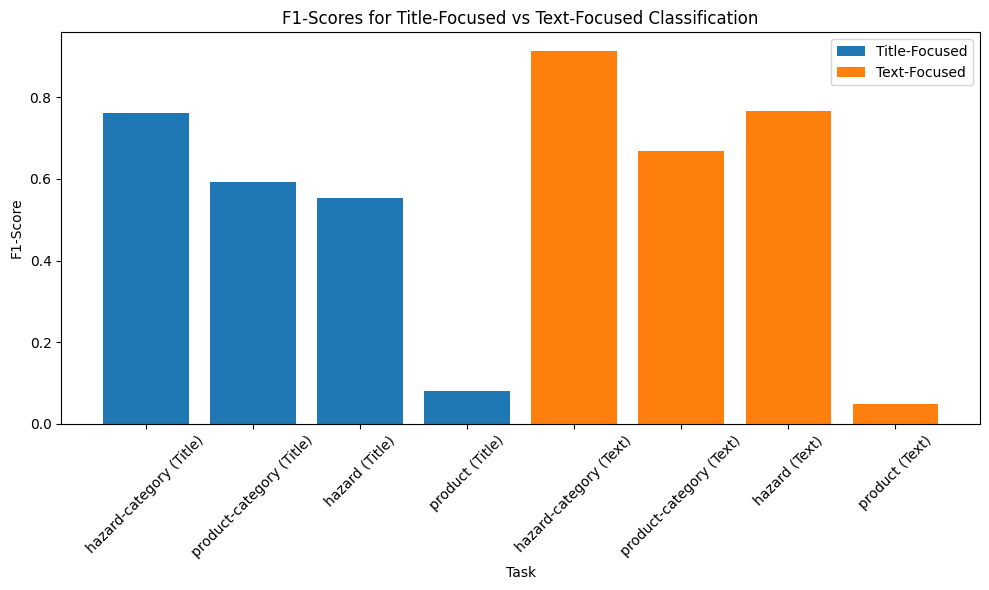

In [17]:
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(10, 6))

# Plotting Title-Focused F1-scores
plt.bar(f1_scores_title_df['Task'], f1_scores_title_df['F1-Score'], label='Title-Focused')

# Plotting Text-Focused F1-scores
plt.bar(f1_scores_text_df['Task'], f1_scores_text_df['F1-Score'], label='Text-Focused')

# Adding labels and title
plt.xlabel('Task')
plt.ylabel('F1-Score')
plt.title('F1-Scores for Title-Focused vs Text-Focused Classification')
plt.xticks(rotation=45)
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()


## Justification for Using F1-Weighted for Model Comparison:

**1. Balanced Measure of Precision and Recall:**

The F1-weighted score is particularly useful for evaluating models in imbalanced datasets, like those shown in the hazard and product category distributions. In these plots, some classes, such as allergens or ice cream, are highly overrepresented, while others are underrepresented. The F1-score effectively balances precision (correct positive predictions) and recall (capturing actual positives), providing a more reliable metric for model performance, especially in cases where the data distribution is skewed.

**2. Handling Class Imbalance:**

Given the imbalances in both product categories and hazard categories, where certain categories dominate while others have few instances (e.g., migration and food additives), F1-weighted helps address this issue by giving more weight to frequent classes while ensuring that underrepresented classes are not neglected. This makes the F1-weighted score more suitable for datasets like the ones presented, where the data distribution heavily favors some classes over others.

**3. Avoiding the "Accuracy Paradox":**

As demonstrated by the skewed distributions of hazard categories and product categories, accuracy can be misleading in imbalanced datasets. For example, if a model predominantly predicts the majority class (e.g., "meat, egg, and dairy products" or "Listeria monocytogenes"), it might achieve high accuracy without effectively identifying less frequent but important categories. The F1-weighted score prevents this by considering both precision and recall, offering a more objective evaluation that avoids the "accuracy paradox."

**4. Handling Undefined F1-Score:**

In cases where some classes are entirely missing from predictions (like some less frequent hazard categories or products), the F1-score could become undefined. The zero_division=0 option in F1-weighted ensures that these situations are handled gracefully, providing a meaningful value even in cases where some classes have no predicted instances. This approach allows for a comprehensive comparison of model performance across all classes, regardless of their frequency in the dataset.

## Analysis of F1-Scores


## Collected F1-Scores for Title-Focused Classification:

| Task                        | F1-Score |
|-----------------------------|----------|
| hazard-category (Title)     | 0.7614   |
| product-category (Title)    | 0.5926   |
| hazard (Title)              | 0.5533   |
| product (Title)             | 0.0798   |

### Analysis:
- **hazard-category (Title)**: F1-Score = 0.7614  
  Good performance in predicting hazard categories based on the title.

- **product-category (Title)**: F1-Score = 0.5926  
  Moderate performance in predicting product categories based on the title.

- **hazard (Title)**: F1-Score = 0.5533  
  Reasonable performance in predicting the hazard from the title.

- **product (Title)**: F1-Score = 0.0798  
  Very poor performance, indicating that the model struggles in predicting product-related information from the title.

---

## Collected F1-Scores for Text-Focused Classification:

| Task                        | F1-Score |
|-----------------------------|----------|
| hazard-category (Text)      | 0.9129   |
| product-category (Text)     | 0.6682   |
| hazard (Text)               | 0.7671   |
| product (Text)              | 0.0479   |

### Analysis:
- **hazard-category (Text)**: F1-Score = 0.9129  
  Excellent performance in predicting hazard categories from the text, showing the model's ability to classify with high accuracy from longer descriptions.

- **product-category (Text)**: F1-Score = 0.6682  
  Strong performance in predicting product categories from the text, but not as high as the hazard-category prediction.

- **hazard (Text)**: F1-Score = 0.7671  
  Good performance in predicting hazards from the text, although slightly lower than hazard-category classification.

- **product (Text)**: F1-Score = 0.0479  
  Very poor performance, similar to the title-focused classification, indicating significant challenges in predicting product-related information from text.

---

## Key Insights:
- **Title vs Text Focus**: The model performs better in text-focused tasks compared to title-focused tasks.
- **Strongest Task**: The highest F1-score (0.9129) is achieved for hazard-category classification in the text-focused task.
- **Weakest Task**: Both in the title-focused and text-focused classifications, the task related to predicting "product" is the weakest, with very low F1-scores.
- **Improvement Potential**: The F1-scores suggest areas where the model could be improved, especially for product-related classifications in both title and text.
